In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import seaborn as sns
import holidays
import lightgbm as lgb
import tensorflow as tf, deeptables as dt
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.python.keras import backend as K
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets
import joblib

print('Tensorflow version:', tf.__version__)
print('DeepTables version:', dt.__version__)

# large number of warnings in data processing step
import warnings
warnings.filterwarnings("ignore")


# fast ai libraries
from fastai.tabular.all import *

# constants
SEED = 2024 # global seed for notebook
BATCH_SIZE = 1024
EPOCHS = 20

#library from Yelim
from statsmodels.tsa.stattools import acf, pacf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from addfunc_YL import DataTransformer
from addfunc_JY import TrainDataTransform

Tensorflow version: 2.15.0
DeepTables version: 0.2.6


In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np 
import pandas as pd 
import polars as pl 
import matplotlib.pyplot as plt 
import holidays


from datetime import timedelta

from addfunc_YL import DataTransformer
from addfunc_JY import TrainDataTransform

In [17]:
class DataStorage:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    
    # root = "/Data/home/limkim/Enefit" #change
    root = "/Data/home/jwmoon/kaggle/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
        "prediction_unit_id", #add_JW
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = self.df_electricity_prices.with_columns(
            self.df_electricity_prices['euros_per_mwh'].abs().alias('euros_per_mwh')
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )
        
        ####################
        # add juwon
        ####################
        def _interpolate_group(group):
            group['target'] = group['target'].interpolate(method='linear')
            return group
        
        def fill_target(df):
            return pl.DataFrame(df.to_pandas().groupby(['prediction_unit_id', 'is_consumption']).apply(_interpolate_group))
        
        def fill_radiation(df):
            rad = df.to_pandas()['surface_solar_radiation_downwards'].values
            idx = df['surface_solar_radiation_downwards'].is_null().to_numpy().nonzero()[0]
            for i, ind in enumerate(idx):
                tmp = df[idx][i]
                df_b1 = df.filter(
                    pl.col('latitude')==tmp['latitude'], pl.col('longitude')==tmp['longitude'],
                    abs(pl.col('forecast_datetime') - tmp['forecast_datetime']) < timedelta(days=2),
                    pl.col('forecast_datetime').dt.hour() == tmp['forecast_datetime'].dt.hour(),
                    pl.col('hours_ahead') == tmp['hours_ahead'])
                fillValue = df_b1['direct_solar_radiation'][1] / ((np.divide(df_b1['direct_solar_radiation'][0], df_b1['surface_solar_radiation_downwards'][0]) +
                    np.divide(df_b1['direct_solar_radiation'][2], df_b1['surface_solar_radiation_downwards'][2]))/2)
                rad[ind] = fillValue
            df.replace('surface_solar_radiation_downwards', pl.Series(rad))
            return df
        
        def fill_summertime(df):
            missingDate = list(set(pd.date_range('2021-09-01', '2023-06-02', freq='h')[3:-22]) - set(df.to_pandas()['forecast_datetime'].unique()))
            hrs_ahead = 2
            add_df = pd.DataFrame()
            for date in missingDate:
                tmp = df.filter(abs(pl.col('forecast_datetime') - date) < timedelta(hours=2),
                                pl.col('hours_ahead') <= 2).sort('latitude', 'longitude').to_pandas()
                for _, row in tmp.iterrows():
                    if row['hours_ahead'] == 1:
                        values_1 = row
                    elif row['hours_ahead'] == 2:
                        values_2 = row
                        average_values = pd.Series([(v1+v2)/2 if c != 'forecast_datetime' else date for (v1,v2,c) in zip(values_1,values_2,values_2.keys())],
                                                index=values_2.keys())
                        average_values['hours_ahead'] = hrs_ahead
                        add_df = pd.concat([add_df, average_values.to_frame().T]).reset_index(drop=True)
            return pl.DataFrame(pd.concat([df.to_pandas(), add_df]).reset_index(drop=True))

        def snow2water(df): # for historical: [cm]/7->[mm]
            df.with_columns(
                (df['snowfall']/7).alias('snowfall'))
            return df

        def separateTP(df): # forecast TP -> (rain, snow2water)
            df.with_columns(
                (df['total_precipitation'] - df['snowfall']/100).alias('rain'))
            return df

        def _exp(x):
            return np.exp(x) /np.exp(48)
            
        def expForecastHr(df):
            df.with_columns(
                df['hours_ahead'].apply(_exp).alias('exp_hours_ahead'))
            return df
        
        def histRoll(df): # roll -1hr, for only T & T_d
            pass
            return df
    
        self.df_data = fill_target(self.df_data)
        self.df_forecast_weather = fill_radiation(self.df_forecast_weather)
        self.df_forecast_weather = fill_summertime(self.df_forecast_weather)
        self.df_forecast_weather = separateTP(self.df_forecast_weather)
        self.df_forecast_weather = expForecastHr(self.df_forecast_weather)
        self.df_historical_weather = snow2water(self.df_historical_weather)
        self.df_historical_weather = histRoll(self.df_historical_weather)

        ####################
        # add juwon (end)
        ####################

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [18]:
class FeaturesGenerator:
    """
    This class was copied out from:
    https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
    """
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            1 * 24,
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
            6,      ###
            12,     ###
            84,     ###
            3096,   ### add juwon
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 1, 24 * 2),
            ("target", 24 * 2, 24 * 3),
            ("target", 24 * 3, 24 * 4),
            ("target", 24 * 4, 24 * 5),
            ("target", 24 * 5, 24 * 6),
            ("target", 24 * 6, 24 * 7),
            ("target", 24 * 1, 24 * 7),
            ("target", 24 * 1, 24 * 14),
            ("target", 24 * 7, 24 * 14),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
           "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [19]:
def convert_2_dataloader(df):

    # define categorical and continous numerical feature column names (on small number of features)
    # from train.csv
    cat_names = ["county", "is_business", "product_type", "is_consumption", "segment"]
    # from datetime column
    cat_names += ['sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)']
    # from https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79 notebook
    cat_names += ['country_holiday']
    
    # from client.csv
    cont_names = ["installed_capacity", "eic_count"]
    
    # from forecast_weather.csv (next 0 hours)
    cont_names += [_ for _ in df.columns if "_forecast_0h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_0h" in _]
    # from forecast_weather.csv (next 24 hours)
    cont_names += [_ for _ in df.columns if "_forecast_24h" in _]
    cont_names += [_ for _ in df.columns if "_forecast_local_24h" in _]
    
    # from historical_weather.csv (last 24/48 hours)
    cont_names += [_ for _ in df.columns if "_historical_24h" in _]
    cont_names += [_ for _ in df.columns if "_historical_48h" in _]
    cont_names += [_ for _ in df.columns if "_historical_local_48h" in _]
    
    # add all historical target values (last n hours)
    cont_names += df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    cont_names += ['target_mean', 'target_std']
    
    # add ratios between last kown target values
    cont_names += df.filter(regex=("target_ratio_.[0-9]")).columns.tolist()
    
    procs = [Categorify, FillMissing, Normalize]
    
    # log transform target variable
    df.loc[:, 'target'] = np.log1p(df['target'])
        
    # convert pandas DataFrame to fastai DataLoader object
    # code snippet taken from
    # https://docs.fast.ai/tabular.learner.html
    splits = RandomSplitter(valid_pct=0.2, seed = SEED)(df)
    
    # tabular object (only categorical features)
    to = TabularPandas(df[cat_names + cont_names + ["target"]],
                       procs = procs,
                       cat_names = cat_names,
                       cont_names = cont_names,
                       y_names = ["target"],
                       splits=splits)
    # create dataloader
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dls = to.dataloaders(BATCH_SIZE, device = device)
     
    # return all dataloaders as tuple
    return dls

def add_custom_features(df):
    """
    Function inspired by notebook:
    https://www.kaggle.com/code/albansteff/enefit-estonian-holidays-lb-65-79
    """
    
    # code bellow same as in NB v17 add_holidays_as_binary_features function
    estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
    estonian_holidays = [pd.to_datetime(_) for _ in estonian_holidays.keys()]
    
    #df['date'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day)) #kaggle에서 오류나서 한 줄 추가했음
    df['country_holiday'] = df['date'].isin(estonian_holidays) * 1
    del df['date']
    
    # log transform histrocial target values
    _cols = df.filter(regex=("target_.[0-9]*h")).columns.tolist()
    for _col in _cols:
        df.loc[:, _col] = np.log1p(df[_col])        
    
    return df

In [35]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [21]:
train_dataset = features_generator.generate_features(data_storage.df_data)
# exclude rows with missing target value
train_dataset = train_dataset[train_dataset['target'].notnull()]
# add estonian holidays
train_dataset = add_custom_features(train_dataset)

In [22]:
clist = train_dataset.columns.tolist()
print(clist)

['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'day', 'weekday', 'month', 'year', 'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)', 'eic_count', 'installed_capacity', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation', 'temperature_forecast_local_0h', 'dewpoint_forecast_local_0h', 'cloudcover_high_forecast_local_0h', 'cloudcover_low_forecast_local_0h', 'cloudcover_mid_forecast_local_0h', 'cloudcover_total_forecast_local_0h', '10_metre_u_wind_component_forecast_local_0h', '10_metre_v_wind_component_forecast_local_0h', 'direct_solar_radiation_forecast_local_0h', 'surface_solar_radiation_downwards_forecast_local_0h', 'snowfall_forecast_local_0h', 'total_precipitation_forecast_local_0h', 'temperature_forecast_168h', 'dewpoint_fore

In [23]:
#add yelim
train_dataset = DataTransformer(train_dataset)
train_dataset = train_dataset.transform()

#add joonyong
train_dataset = TrainDataTransform(train_dataset)
train_dataset = train_dataset.transform()

In [24]:
train_dataset.head()

,county,is_business,product_type,is_consumption,prediction_unit_id,day,weekday,month,year,segment,sin(dayofyear),cos(dayofyear),sin(hour),cos(hour),eic_count,installed_capacity,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,temperature_forecast_local_0h,dewpoint_forecast_local_0h,cloudcover_high_forecast_local_0h,cloudcover_low_forecast_local_0h,cloudcover_mid_forecast_local_0h,cloudcover_total_forecast_local_0h,10_metre_u_wind_component_forecast_local_0h,10_metre_v_wind_component_forecast_local_0h,direct_solar_radiation_forecast_local_0h,surface_solar_radiation_downwards_forecast_local_0h,snowfall_forecast_local_0h,total_precipitation_forecast_local_0h,temperature_forecast_168h,dewpoint_forecast_168h,cloudcover_high_forecast_168h,cloudcover_low_forecast_168h,cloudcover_mid_forecast_168h,cloudcover_total_forecast_168h,10_metre_u_wind_component_forecast_168h,10_metre_v_wind_component_forecast_168h,direct_solar_radiation_forecast_168h,surface_solar_radiation_downwards_forecast_168h,snowfall_forecast_168h,total_precipitation_forecast_168h,temperature_forecast_local_168h,dewpoint_forecast_local_168h,cloudcover_high_forecast_local_168h,cloudcover_low_forecast_local_168h,cloudcover_mid_forecast_local_168h,cloudcover_total_forecast_local_168h,10_metre_u_wind_component_forecast_local_168h,10_metre_v_wind_component_forecast_local_168h,direct_solar_radiation_forecast_local_168h,surface_solar_radiation_downwards_forecast_local_168h,snowfall_forecast_local_168h,total_precipitation_forecast_local_168h,temperature_historical_48h,dewpoint_historical_48h,rain,snowfall_historical_48h,surface_pressure,cloudcover_total_historical_48h,cloudcover_low_historical_48h,cloudcover_mid_historical_48h,cloudcover_high_historical_48h,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation_historical_48h,diffuse_radiation,temperature_historical_local_48h,dewpoint_historical_local_48h,rain_historical_local_48h,snowfall_historical_local_48h,surface_pressure_historical_local_48h,cloudcover_total_historical_local_48h,cloudcover_low_historical_local_48h,cloudcover_mid_historical_local_48h,cloudcover_high_historical_local_48h,windspeed_10m_historical_local_48h,winddirection_10m_historical_local_48h,shortwave_radiation_historical_local_48h,direct_solar_radiation_historical_local_48h,diffuse_radiation_historical_local_48h,temperature_historical_168h,dewpoint_historical_168h,rain_historical_168h,snowfall_historical_168h,surface_pressure_historical_168h,cloudcover_total_historical_168h,cloudcover_low_historical_168h,cloudcover_mid_historical_168h,cloudcover_high_historical_168h,windspeed_10m_historical_168h,winddirection_10m_historical_168h,shortwave_radiation_historical_168h,direct_solar_radiation_historical_168h,diffuse_radiation_historical_168h,temperature_historical_local_168h,dewpoint_historical_local_168h,rain_historical_local_168h,snowfall_historical_local_168h,surface_pressure_historical_local_168h,cloudcover_total_historical_local_168h,cloudcover_low_historical_local_168h,cloudcover_mid_historical_local_168h,cloudcover_high_historical_local_168h,windspeed_10m_historical_local_168h,winddirection_10m_historical_local_168h,shortwave_radiation_historical_local_168h,direct_solar_radiation_historical_local_168h,diffuse_radiation_historical_local_168h,temperature_historical_24h,dewpoint_historical_24h,rain_historical_24h,snowfall_historical_24h,surface_pressure_historical_24h,cloudcover_total_historical_24h,cloudcover_low_historical_24h,cloudcover_mid_historical_24h,cloudcover_high_historical_24h,windspeed_10m_historical_24h,winddirection_10m_historical_24h,shortwave_radiation_historical_24h,direct_solar_radiation_historical_24h,diffuse_radiation_historical_24h,target_24h,target_48h,target_72h,target_96h,target_120h,target_144h,target_168h,target_192h,target_216h,target_240h

In [29]:
[c for c in train_dataset.columns]

['county',
 'is_business',
 'product_type',
 'is_consumption',
 'prediction_unit_id',
 'day',
 'weekday',
 'month',
 'year',
 'segment',
 'sin(dayofyear)',
 'cos(dayofyear)',
 'sin(hour)',
 'cos(hour)',
 'eic_count',
 'installed_capacity',
 'temperature',
 'dewpoint',
 'cloudcover_high',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_total',
 '10_metre_u_wind_component',
 '10_metre_v_wind_component',
 'direct_solar_radiation',
 'surface_solar_radiation_downwards',
 'snowfall',
 'total_precipitation',
 'temperature_forecast_local_0h',
 'dewpoint_forecast_local_0h',
 'cloudcover_high_forecast_local_0h',
 'cloudcover_low_forecast_local_0h',
 'cloudcover_mid_forecast_local_0h',
 'cloudcover_total_forecast_local_0h',
 '10_metre_u_wind_component_forecast_local_0h',
 '10_metre_v_wind_component_forecast_local_0h',
 'direct_solar_radiation_forecast_local_0h',
 'surface_solar_radiation_downwards_forecast_local_0h',
 'snowfall_forecast_local_0h',
 'total_precipitation_forecast_local_0h',
 'te

In [28]:
for c in train_dataset.columns:
    if train_dataset[c].isnull().sum() > 0:
        print(c, train_dataset[c].isnull().sum())

eic_count 2400
installed_capacity 2400
temperature_forecast_local_0h 24768
dewpoint_forecast_local_0h 24768
cloudcover_high_forecast_local_0h 24768
cloudcover_low_forecast_local_0h 24768
cloudcover_mid_forecast_local_0h 24768
cloudcover_total_forecast_local_0h 24768
10_metre_u_wind_component_forecast_local_0h 24768
10_metre_v_wind_component_forecast_local_0h 24768
direct_solar_radiation_forecast_local_0h 24768
surface_solar_radiation_downwards_forecast_local_0h 24768
snowfall_forecast_local_0h 24768
total_precipitation_forecast_local_0h 24768
temperature_forecast_local_168h 24768
dewpoint_forecast_local_168h 24768
cloudcover_high_forecast_local_168h 24768
cloudcover_low_forecast_local_168h 24768
cloudcover_mid_forecast_local_168h 24768
cloudcover_total_forecast_local_168h 24768
10_metre_u_wind_component_forecast_local_168h 24768
10_metre_v_wind_component_forecast_local_168h 24768
direct_solar_radiation_forecast_local_168h 24768
surface_solar_radiation_downwards_forecast_local_168h 2476

In [ ]:
#train_dataset.to_csv('/Data/home/limkim/Enefit/Kaggle2024_Enefit/baseline.csv', index = False)

# Modeling

In [ ]:
df_train_features = train_dataset[train_dataset['target'].notnull()]
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1651902 entries, 366048 to 2018351
Columns: 205 entries, county to charging_access_estimate_1
dtypes: category(5), float32(162), float64(31), int32(1), int64(2), int8(3), object(1)
memory usage: 1.4+ GB


Learning Rate schedule : 1e-07 to 0.001 to 1e-07


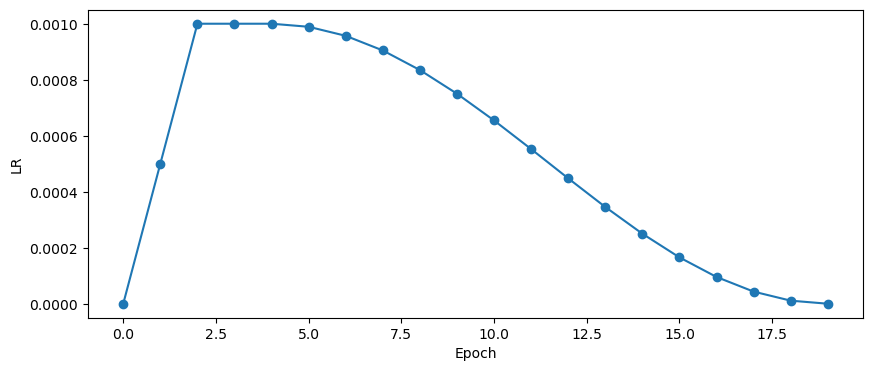

In [ ]:
LR_START = 1e-7
LR_MAX = 1e-3
LR_MIN = 1e-7
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 2
EPOCHS = 20

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10,4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print('Learning Rate schedule : {:.3g} to {:3g} to {:3g}' . \
        format(lr_y[0], max(lr_y), lr_y[-1]))
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
%%time
class CFG:
    nn = True
    lgb = True
    ens_weights = {'nn': 0.5, 'lgb': 0.5}
    epochs = 10
    batch_size = 512
    valid_size = 5e-2
    LR_Scheduler = []  # [LR]
    optimizer = AdamW(learning_rate=1e-3, weight_decay=9e-7)
     
class Model:
    def __init__(self):
        self.conf = ModelConfig(auto_imputation=True,
                                auto_discrete=True,
                                auto_discard_unique=True,
                                categorical_columns='auto',
                                fixed_embedding_dim=False,
                                embeddings_output_dim=4,
                                embedding_dropout=0.3,
                                nets=['dnn_nets'],
                                dnn_params={
                                    'hidden_units': ((512, 0.3, True),
                                                     (256, 0.3, True)),
                                    'dnn_activation': 'relu',
                                },
                                stacking_op='add',
                                output_use_bias=False,
                                optimizer=CFG.optimizer,
                                task='regression',
                                loss='MeanAbsoluteError',
                                metrics='MeanAbsoluteError',
                                earlystopping_patience=1,
                                )
        
        self.lgb_params = {"n_estimators": 2500,
                           "learning_rate": 0.06,
                           "max_depth": 16,
                           "num_leaves": 500,
                           "reg_alpha": 3.5,
                           "reg_lambda": 1.5,
                           "colsample_bytree": 0.9,
                           "colsample_bynode": 0.6,
                           "min_child_samples": 50,
                           "random_state": 0,
                           "objective": "regression_l1",
                           "device": "gpu",
                           "n_jobs": 4,
                           "verbose": -1,
                           }
        
        self.nn_model_consumption = DeepTable(config=self.conf)  
        self.nn_model_production = DeepTable(config=self.conf)
        
        self.lgb_model_consumption = lgb.LGBMRegressor(**self.lgb_params)
        self.lgb_model_production = lgb.LGBMRegressor(**self.lgb_params)

    def fit(self, df_train_features):
        print('nn = '+str(CFG.nn))
        print('lgb = '+str(CFG.lgb))
        
        if CFG.nn == True:
            
            print('\n',"nn model consumption training.",'\n')
            mask = df_train_features["is_consumption"] == 1
            self.nn_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
            # Avoid saving error
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for i, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(i)
                    CFG.optimizer.weights[i] = tf.Variable(var, name=name)
            self.conf = self.conf._replace(optimizer=CFG.optimizer)   
            self.nn_model_production = DeepTable(config=self.conf)
            
            print('\n',"nn model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.nn_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
                validation_split=CFG.valid_size, shuffle=False,
                batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2,
                callbacks=CFG.LR_Scheduler
            )
        
        if CFG.lgb == True:
            
            print('\n',"lgb model consumption training.")
            mask = df_train_features["is_consumption"] == 1
            self.lgb_model_consumption.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
            print('\n',"lgb model production training.",'\n')
            mask = df_train_features["is_consumption"] == 0
            self.lgb_model_production.fit(
                X=df_train_features[mask].drop(columns=["target"]),
                y=df_train_features[mask]["target"]
                - df_train_features[mask]["target_48h"].fillna(0),
            )
        
    def plot_nn_model(self):
        if CFG.nn == True:
            return plot_model(self.nn_model_consumption.get_model().model)    

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))
        
        if CFG.nn == True and CFG.lgb == True:
            
            print('\n',"nn & lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_consumption.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_consumption.predict(df_features[mask])),
                0,
                np.inf,
            )
        
            print('\n',"nn & lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + CFG.ens_weights['nn'] * (self.nn_model_production.predict(df_features[mask])[:,0])
                + CFG.ens_weights['lgb'] * (self.lgb_model_production.predict(df_features[mask])),
                0,
                np.inf,
            )
        
        elif CFG.nn == True and CFG.lgb == False:
            
            print('\n',"nn model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_consumption.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
            print('\n',"nn model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.nn_model_production.predict(df_features[mask])[:,0],
                0,
                np.inf,
            )
            
        elif CFG.nn == False and CFG.lgb == True:
            
            print('\n',"lgb model consumption prediction.",'\n')
            mask = df_features["is_consumption"] == 1
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_consumption.predict(df_features[mask]),
                0,
                np.inf,
            )
            
            print('\n',"lgb model production prediction.",'\n')
            mask = df_features["is_consumption"] == 0
            predictions[mask.values] = np.clip(
                df_features[mask]["target_48h"].fillna(0).values
                + self.lgb_model_production.predict(df_features[mask]),
                0,
                np.inf,
            )
            
        else:
            raise ValueError("No models has been trained.")
            
        return predictions
    
    
model = Model()
model.fit(df_train_features)

joblib.dump(model.lgb_model_consumption, 'lgb_model_consumption.joblib')
joblib.dump(model.lgb_model_production, 'lgb_model_production.joblib')

nn_model_consumption = model.nn_model_consumption.get_model().model
nn_model_consumption.save('nn_model_consumption.h5')

nn_model_production = model.nn_model_production.get_model().model
nn_model_production.save('nn_model_production.h5')


nn = True
lgb = True

 nn model consumption training. 

01-22 16:28:17 I deeptables.m.deeptable.py 337 - X.Shape=(825951, 204), y.Shape=(825951,), batch_size=512, config=ModelConfig(name='conf-1', nets=['dnn_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics='MeanAbsoluteError', auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=True, auto_discrete=True, auto_discard_unique=True, apply_gbm_features=False, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=False, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.3, stacking_op='add', output_use_bias=False, apply_class_weight=False, optimizer=<tensorflow_addons.optimizers.weight_decay_optimizers.AdamW object at 0x7f2482dc4a60>, loss='MeanAbsoluteError', dnn_params={'hidden_units': ((512, 0.3, True), (256, 0.3, T

01-22 16:28:18 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-22 16:28:18 I deeptables.m.preprocessor.py 261 - Preparing features...
01-22 16:28:20 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.7317285537719727s
01-22 16:28:20 I deeptables.m.preprocessor.py 341 - Data imputation...
01-22 16:28:35 I deeptables.m.preprocessor.py 383 - Imputation taken 14.850428104400635s
01-22 16:28:35 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-22 16:28:36 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.8660624027252197s
01-22 16:28:36 I deeptables.m.preprocessor.py 398 - Data discretization...
01-22 16:28:36 I hypernets.t.sklearn_ex.py 716 - 171 variables to discrete.
01-22 16:29:00 I deeptables.m.preprocessor.py 404 - Discretization taken 23.721153736114502s
01-22 16:29:08 I deeptables.m.preprocessor.py 196 - fit_transform taken 49.51470375061035s
01-22 16:29:08 I deeptables.m.deeptable.py 353 - Training...
01-22 16:29:08 I deeptables.m.deeptable.py 752 - Injected a callback [EarlyStopping]. monitor:val_

2024-01-22 16:29:08.305359: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


01-22 16:29:10 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=512, shuffle=False, drop_remainder=True
01-22 16:29:17 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=512, shuffle=False, drop_remainder=True
01-22 16:29:18 I deeptables.m.deepmodel.py 231 - Building model...
01-22 16:29:19 I deeptables.m.deepmodel.py 287 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (176)', 'input_continuous_all: (171)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [18, 4, 6, 71, 4, 4, 4, 4, 3, 6, 6, 4, 4, 7, 8, 13, 13, 12, 13, 12, 12, 13, 13, 11, 11, 11, 12, 23, 22, 20, 20, 20, 20, 23, 23, 20, 20, 16, 19, 13, 13, 12, 13, 12, 12, 13, 13, 11, 11, 11, 12

01-22 16:34:19 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 53, in _iter_data
    yield from self._iter_data(x)
  File "/Data/home/limkim/anaconda3/lib/python3.9/site-packages/hypernets/tabular/data_hasher.py", line 61, in _iter_data
    pickle.dump(data, buf, protocol=pickle.HIGHEST_PROTOCOL)



01-22 16:34:19 I deeptables.m.preprocessor.py 261 - Preparing features...
01-22 16:34:21 I deeptables.m.preprocessor.py 336 - Preparing features taken 1.5091071128845215s
01-22 16:34:21 I deeptables.m.preprocessor.py 341 - Data imputation...
01-22 16:34:35 I deeptables.m.preprocessor.py 383 - Imputation taken 14.517640590667725s
01-22 16:34:35 I deeptables.m.preprocessor.py 388 - Categorical encoding...
01-22 16:34:36 I deeptables.m.preprocessor.py 393 - Categorical encoding taken 0.85685133934021s
01-22 16:34:36 I deeptables.m.preprocessor.py 398 - Data discretization...
01-22 16:34:36 I hypernets.t.sklearn_ex.py 716 - 172 variables to discrete.
01-22 16:34:58 I deeptables.m.preprocessor.py 404 - Discretization taken 21.821974515914917s
01-22 16:35:05 I deeptables.m.preprocessor.py 196 - fit_transform taken 46.03046536445618s
01-22 16:35:05 I deeptables.m.deeptable.py 353 - Training...
01-22 16:35:07 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPanda

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: daypart: object

In [ ]:
# # 저장되어있는 모델 사용하는 경우

# lgb_model_consumption = joblib.load('lgb_model_consumption.joblib')
# lgb_model_production = joblib.load('lgb_model_production.joblib')

# from tensorflow.keras.models import load_model
# model_file = 'nn_model_production.h5'
# loaded_model = load_model(model_file)

In [ ]:
model.plot_nn_model()

# Submit API

import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [ ]:
%%time
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:

    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    df_test = data_storage.preprocess_test(df_test)
    
    df_test_features = features_generator.generate_features(df_test)

        #add yelim
    test_dataset = DataTransformer(df_test_features)
    test_dataset = test_dataset.transform()

    #add joonyong
    test_dataset = TrainDataTransform(test_dataset)
    test_dataset = test_dataset.transform()

    test_dataset = DataStorageTransform(test_dataset)
    df_test_features = test_dataset.transform()
    
    df_sample_prediction["target"] = model.predict(df_test_features)
    
    env.predict(df_sample_prediction)